In [16]:
# Imports
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, datasets, models
import json
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pretrained ResNet-34 model
resnet_model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
resnet_model.eval().to(device)

# Define normalization (ImageNet statistics)
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

transform_pipeline = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

# Load dataset
data_dir = "content/TestDataSet/TestDataSet"
image_dataset = datasets.ImageFolder(root=data_dir, transform=transform_pipeline)
data_loader = DataLoader(image_dataset, batch_size=32, shuffle=False)

print(f"📂 Dataset loaded with {len(image_dataset)} images from {len(image_dataset.classes)} categories.")

# Load class label mappings
json_path = os.path.join(data_dir, "labels_list.json")
with open(json_path, "r") as f:
    label_data = json.load(f)

# Create label index mappings
imagenet_label_ids = [int(line.split(":")[0]) for line in label_data]
folder_to_imagenet = {folder: imagenet_label_ids[i] for i, folder in enumerate(image_dataset.classes)}
id_to_classname = {int(line.split(":")[0]): line.split(":")[1].strip() for line in label_data}

# Evaluate accuracy
correct_top1 = 0
correct_top5 = 0
sample_count = 0

with torch.no_grad():
    for images, labels in tqdm(data_loader, desc="Evaluating"):
        images = images.to(device)

        # Convert dataset class indices to actual ImageNet indices
        true_indices = torch.tensor([folder_to_imagenet[image_dataset.classes[label]] for label in labels]).to(device)

        outputs = resnet_model(images)
        _, top5_predictions = outputs.topk(5, dim=1)

        # Top-1 accuracy
        correct_top1 += (top5_predictions[:, 0] == true_indices).sum().item()

        # Top-5 accuracy
        for idx in range(images.size(0)):
            if true_indices[idx].item() in top5_predictions[idx]:
                correct_top5 += 1

        sample_count += images.size(0)

# Compute final accuracy scores
top1_score = correct_top1 / sample_count
top5_score = correct_top5 / sample_count

print(f"\n✅ Top-1 Accuracy: {top1_score:.4f}")
print(f"✅ Top-5 Accuracy: {top5_score:.4f}")

📂 Dataset loaded with 500 images from 100 categories.


Evaluating: 100%|██████████| 16/16 [00:02<00:00,  8.00it/s]


✅ Top-1 Accuracy: 0.7620
✅ Top-5 Accuracy: 0.9420


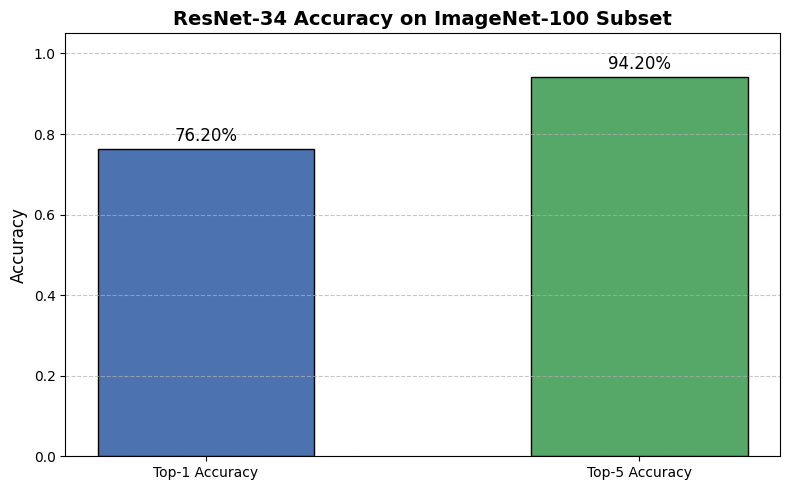

In [17]:
# Create accuracy bar plot
accuracies = [top1_score, top5_score]
labels = ["Top-1 Accuracy", "Top-5 Accuracy"]
colors = ["#4C72B0", "#55A868"]  # Custom blue and green

plt.figure(figsize=(8, 5))
bars = plt.bar(labels, accuracies, color=colors, width=0.5, edgecolor='black')

# Annotate bars with percentage values
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.02, f"{height:.2%}", ha='center', fontsize=12)

# Aesthetics
plt.ylim(0, 1.05)
plt.ylabel("Accuracy", fontsize=12)
plt.title("ResNet-34 Accuracy on ImageNet-100 Subset", fontsize=14, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

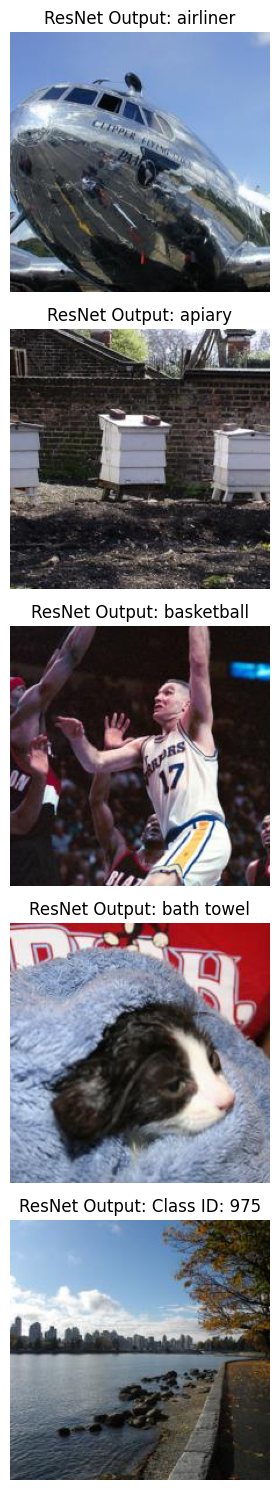

In [18]:
# Function to visualize predictions
def visualize_predictions(dataset, model, sample_indices, idx_to_label, mean=imagenet_mean, std=imagenet_std):
    """
    Display selected normalized input images along with model predictions.

    Parameters:
    - dataset: ImageFolder dataset containing normalized tensors
    - model: Pretrained classification model
    - sample_indices: List of indices for which predictions are shown
    - idx_to_label: Dictionary mapping ImageNet indices to labels
    - mean, std: Normalization statistics for denormalization
    """
    model.eval()
    num_samples = len(sample_indices)
    fig, axes = plt.subplots(num_samples, 1, figsize=(8, 3 * num_samples))

    if num_samples == 1:
        axes = [axes]

    for idx, ax in zip(sample_indices, axes):
        image_tensor, _ = dataset[idx]
        input_batch = image_tensor.unsqueeze(0).to(device)

        # Denormalize for display
        image_vis = image_tensor.clone()
        for c in range(3):
            image_vis[c] = image_vis[c] * std[c] + mean[c]
        image_vis = torch.clamp(image_vis, 0, 1).permute(1, 2, 0).cpu().numpy()

        with torch.no_grad():
            output = model(input_batch)
            pred_class_id = output.argmax(dim=1).item()

        # Lookup label
        class_label = idx_to_label.get(pred_class_id, f"Class ID: {pred_class_id}")

        ax.imshow(image_vis)
        ax.set_title(f"{model.__class__.__name__} Output: {class_label}", fontsize=12)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Your pre-defined mapping from ImageNet class IDs to labels
imagenet_idx_to_label = {int(entry.split(":")[0]): entry.split(":")[1].strip() for entry in label_data}

# Sample image indices for visualization
sample_indices = [15, 45, 149, 169, 296]
visualize_predictions(image_dataset, resnet_model, sample_indices, imagenet_idx_to_label)

## Task 2

In [21]:
# Imports
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, datasets, models
import json
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pretrained ResNet-34 model
resnet_model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
resnet_model.eval().to(device)

# Define normalization (ImageNet statistics)
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

# Task 1 Dataset (normalized version for evaluation)
transform_pipeline = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

dataset_path = "content/TestDataSet/TestDataSet"
image_dataset = datasets.ImageFolder(root=dataset_path, transform=transform_pipeline)
data_loader = DataLoader(image_dataset, batch_size=32, shuffle=False)

print(f"📂 Dataset loaded with {len(image_dataset)} images from {len(image_dataset.classes)} categories.")

# Load class label mappings (using same variable names from Task 1)
json_path = os.path.join(dataset_path, "labels_list.json")
with open(json_path, "r") as f:
    label_data = json.load(f)

# Mapping ImageNet class labels to dataset class indices
imagenet_label_ids = [int(line.split(":")[0]) for line in label_data]
folder_to_imagenet = {folder: imagenet_label_ids[i] for i, folder in enumerate(image_dataset.classes)}
id_to_classname = {int(line.split(":")[0]): line.split(":")[1].strip() for line in label_data}

# === FGSM Attack ===
def fgsm_attack_raw(model, images, labels, epsilon=0.02):
    images = images.clone().detach().to(device).requires_grad_(True)
    labels = labels.to(device)
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    model.zero_grad()
    loss.backward()
    return torch.clamp(images + epsilon * images.grad.sign(), 0, 1)

# === Generate Adversarial Test Set 1 ===
adv_images_list, adv_labels_list = [], []
for images, labels in tqdm(data_loader, desc="Generating Adversarial Images"):
    true_labels = torch.tensor([folder_to_imagenet[image_dataset.classes[t]] for t in labels]).to(device)
    adv_images = fgsm_attack_raw(resnet_model, images, true_labels)
    adv_images_list.append(adv_images.cpu())
    adv_labels_list.append(true_labels.cpu())

adv_dataset_images = torch.cat(adv_images_list)
adv_dataset_labels = torch.cat(adv_labels_list)

# === Verify L∞ Constraint (ε = 0.02) ===
def verify_linf_raw(orig_dataset, adv_tensor, epsilon=0.02, attack_name="FGSM"):
    max_diffs = [
        torch.abs(orig_dataset[i][0] - adv_tensor[i].cpu()).max().item()
        for i in range(len(orig_dataset))
    ]
    max_val = max(max_diffs)
    print(f"🔎 {attack_name} - Max L∞ distance: {max_val:.6f}")

    if max_val <= epsilon + 1e-6:
        print(f"✔️ {attack_name} - ε constraint satisfied\n")
    else:
        print(f"❌ {attack_name} - ε constraint violated\n")

verify_linf_raw(image_dataset, adv_dataset_images, epsilon=0.02, attack_name="FGSM")

# === Evaluate Accuracy on Adversarial Test Set 1 ===
adv_loader = DataLoader(list(zip(adv_dataset_images, adv_dataset_labels)), batch_size=32)
top1, top5, total = 0, 0, 0
with torch.no_grad():
    for images, labels in tqdm(adv_loader, desc="Evaluating on Adversarial Set"):
        images, labels = images.to(device), labels.to(device)
        outputs = resnet_model(images)
        _, top5_preds = outputs.topk(5, dim=1)
        top1 += (top5_preds[:, 0] == labels).sum().item()
        top5 += sum([labels[i].item() in top5_preds[i] for i in range(images.size(0))])
        total += images.size(0)

print(f"⚠️ FGSM Top-1 Accuracy: {top1 / total:.4f}")
print(f"⚠️ FGSM Top-5 Accuracy: {top5 / total:.4f}")

📂 Dataset loaded with 500 images from 100 categories.


Generating Adversarial Images: 100%|██████████| 16/16 [00:02<00:00,  7.80it/s]


🔎 FGSM - Max L∞ distance: 2.117904
❌ FGSM - ε constraint violated



Evaluating on Adversarial Set: 100%|██████████| 16/16 [00:00<00:00, 16.70it/s]

⚠️ FGSM Top-1 Accuracy: 0.2640
⚠️ FGSM Top-5 Accuracy: 0.5060


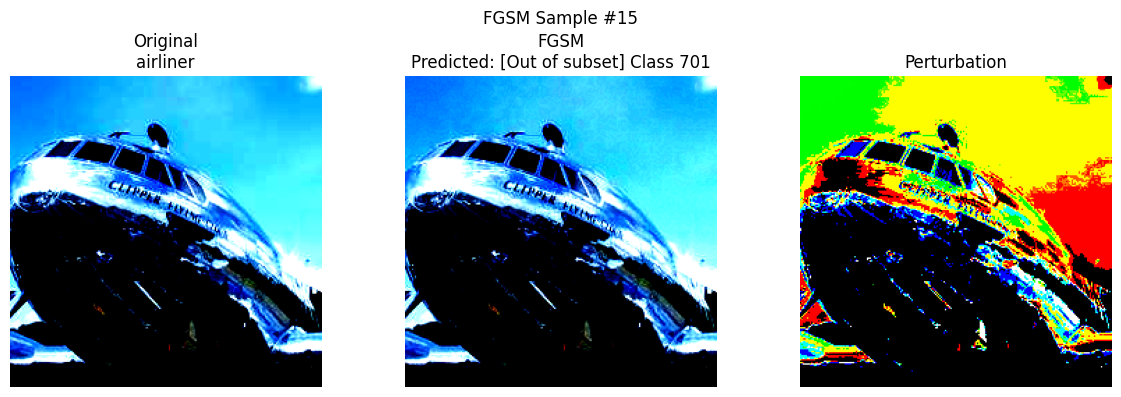

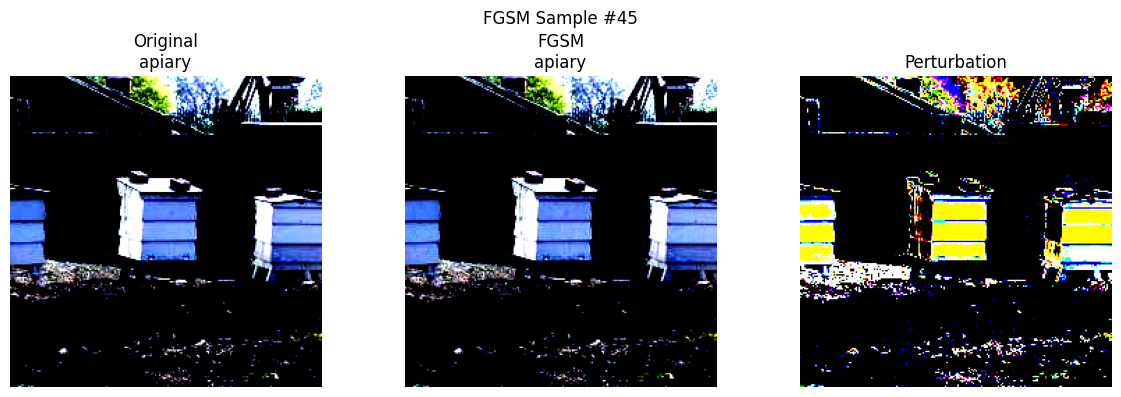

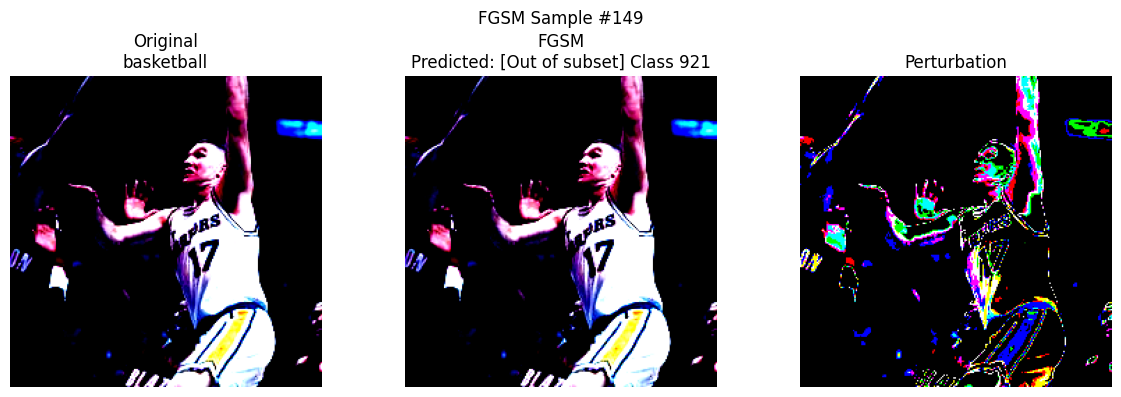

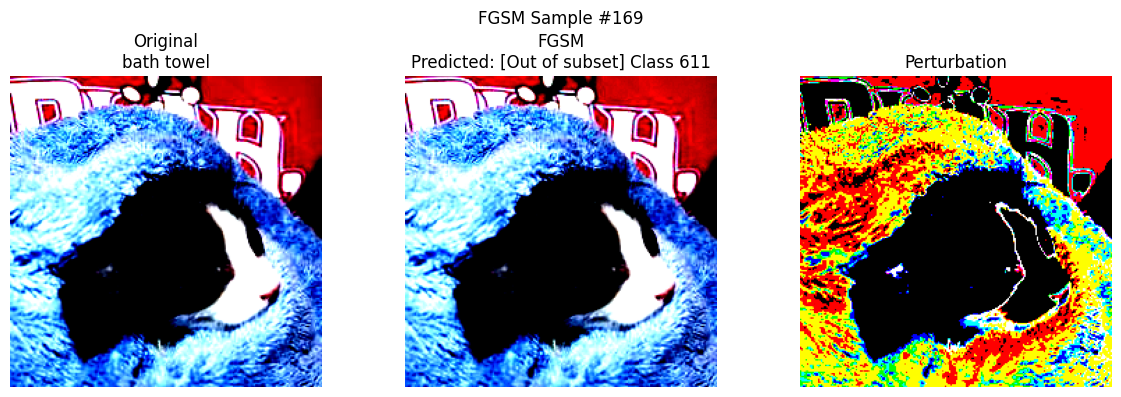

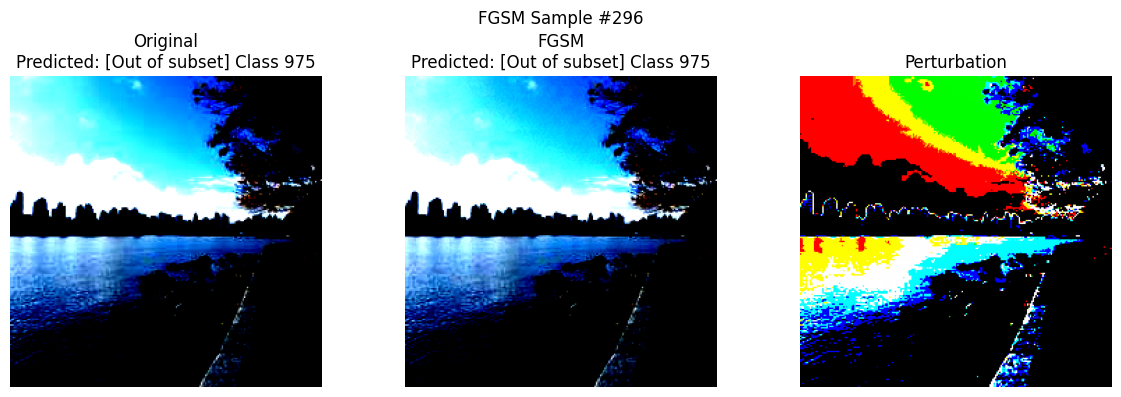

In [22]:
# === Save Dataset ===
torch.save((adv_dataset_images, adv_dataset_labels), "Adversarial_Test_Set_1.pt")

# === Visualization of Adversarial vs Original Images ===
def show_adversarial_comparison(orig_dataset, adv_dataset_images, model, indices, attack_name="FGSM"):
    model.eval()
    for idx in indices:
        orig_img, _ = orig_dataset[idx]
        orig_tensor = orig_img.unsqueeze(0).to(device).float()
        adv_tensor = adv_dataset_images[idx].unsqueeze(0).to(device).float()

        with torch.no_grad():
            orig_pred = model(orig_tensor).argmax(dim=1).item()
            adv_pred = model(adv_tensor).argmax(dim=1).item()

        orig_label = id_to_classname.get(orig_pred, f"Predicted: [Out of subset] Class {orig_pred}")
        adv_label = id_to_classname.get(adv_pred, f"Predicted: [Out of subset] Class {adv_pred}")

        orig_np = torch.clamp(orig_tensor[0], 0, 1).detach().permute(1, 2, 0).cpu().numpy()
        adv_np = torch.clamp(adv_tensor[0], 0, 1).detach().permute(1, 2, 0).cpu().numpy()

        diff_np = np.abs(adv_np - orig_np)

        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(orig_np)
        axs[0].set_title(f"Original\n{orig_label}")
        axs[1].imshow(adv_np)
        axs[1].set_title(f"{attack_name}\n{adv_label}")
        axs[2].imshow(diff_np / diff_np.max())
        axs[2].set_title("Perturbation")
        for ax in axs: ax.axis('off')
        plt.suptitle(f"{attack_name} Sample #{idx}", fontsize=12)
        plt.tight_layout()
        plt.show()

# Select indices for visualization
sample_indices = [15, 45, 149, 169, 296]
show_adversarial_comparison(image_dataset, adv_dataset_images, resnet_model, sample_indices, attack_name="FGSM")

## Task3

In [25]:
# Imports
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, datasets, models
import json
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pretrained ResNet-34 model
resnet_model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
resnet_model.eval().to(device)

# Define normalization (ImageNet statistics)
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

# Dataset (normalized version for evaluation)
transform_pipeline = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

dataset_path = "content/TestDataSet/TestDataSet"
image_dataset = datasets.ImageFolder(root=dataset_path, transform=transform_pipeline)
data_loader = DataLoader(image_dataset, batch_size=32, shuffle=False)

print(f"📂 Dataset loaded with {len(image_dataset)} images from {len(image_dataset.classes)} categories.")

# Load class label mappings (same as Task 1)
json_path = os.path.join(dataset_path, "labels_list.json")
with open(json_path, "r") as f:
    label_data = json.load(f)

# Mapping ImageNet class labels to dataset class indices
imagenet_label_ids = [int(line.split(":")[0]) for line in label_data]
folder_to_imagenet = {folder: imagenet_label_ids[i] for i, folder in enumerate(image_dataset.classes)}
id_to_classname = {int(line.split(":")[0]): line.split(":")[1].strip() for line in label_data}

# === PGD Attack ===
def pgd_attack(model, images, labels, epsilon=0.02, alpha=0.005, iters=10):
    ori_images = images.clone().detach().to(device)
    images = ori_images.clone().detach().requires_grad_(True)

    for _ in range(iters):
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)
        model.zero_grad()
        loss.backward()

        images = images + alpha * images.grad.sign()
        images = torch.max(torch.min(images, ori_images + epsilon), ori_images - epsilon)
        images = torch.clamp(images, 0, 1).detach().requires_grad_(True)

    return images.detach()

# === Generate Adversarial Test Set 2 (PGD) ===
adv2_images_list, adv2_labels_list = [], []
for images, labels in tqdm(data_loader, desc="Generating PGD Adversarial Images"):
    true_labels = torch.tensor([folder_to_imagenet[image_dataset.classes[t]] for t in labels]).to(device)
    adv_images = pgd_attack(resnet_model, images, true_labels)
    adv2_images_list.append(adv_images.cpu())
    adv2_labels_list.append(true_labels.cpu())

adv2_dataset_images = torch.cat(adv2_images_list)
adv2_dataset_labels = torch.cat(adv2_labels_list)

# === Verify L∞ Constraint (ε = 0.02) ===
def verify_linf_raw(orig_dataset, adv_tensor, epsilon=0.02, attack_name="PGD"):
    max_diffs = [
        torch.abs(orig_dataset[i][0] - adv_tensor[i].cpu()).max().item()
        for i in range(len(orig_dataset))
    ]
    max_val = max(max_diffs)
    print(f"🔎 {attack_name} - Max L∞ distance: {max_val:.6f}")

    if max_val <= epsilon + 1e-6:
        print(f"✔️ {attack_name} - ε constraint satisfied\n")
    else:
        print(f"❌ {attack_name} - ε constraint violated\n")

verify_linf_raw(image_dataset, adv2_dataset_images, epsilon=0.02, attack_name="PGD")

# === Evaluate Accuracy on PGD Adversarial Test Set 2 ===
adv2_loader = DataLoader(list(zip(adv2_dataset_images, adv2_dataset_labels)), batch_size=32)
pgd_top1, pgd_top5, total = 0, 0, 0
resnet_model.eval()
with torch.no_grad():
    for images, labels in tqdm(adv2_loader, desc="Evaluating on PGD Adversarial Set"):
        images, labels = images.to(device), labels.to(device)
        outputs = resnet_model(images)
        _, top5_preds = outputs.topk(5, dim=1)
        pgd_top1 += (top5_preds[:, 0] == labels).sum().item()
        pgd_top5 += sum([labels[i].item() in top5_preds[i] for i in range(images.size(0))])
        total += images.size(0)

print(f"⚠️ PGD Top-1 Accuracy: {pgd_top1 / total:.4f}")
print(f"⚠️ PGD Top-5 Accuracy: {pgd_top5 / total:.4f}")

# === Save PGD Adversarial Dataset ===
torch.save((adv2_dataset_images, adv2_dataset_labels), "Adversarial_Test_Set_2.pt")


📂 Dataset loaded with 500 images from 100 categories.


Generating PGD Adversarial Images: 100%|██████████| 16/16 [00:09<00:00,  1.76it/s]


🔎 PGD - Max L∞ distance: 2.117904
❌ PGD - ε constraint violated



Evaluating on PGD Adversarial Set: 100%|██████████| 16/16 [00:01<00:00, 14.68it/s]


⚠️ PGD Top-1 Accuracy: 0.0040
⚠️ PGD Top-5 Accuracy: 0.0680


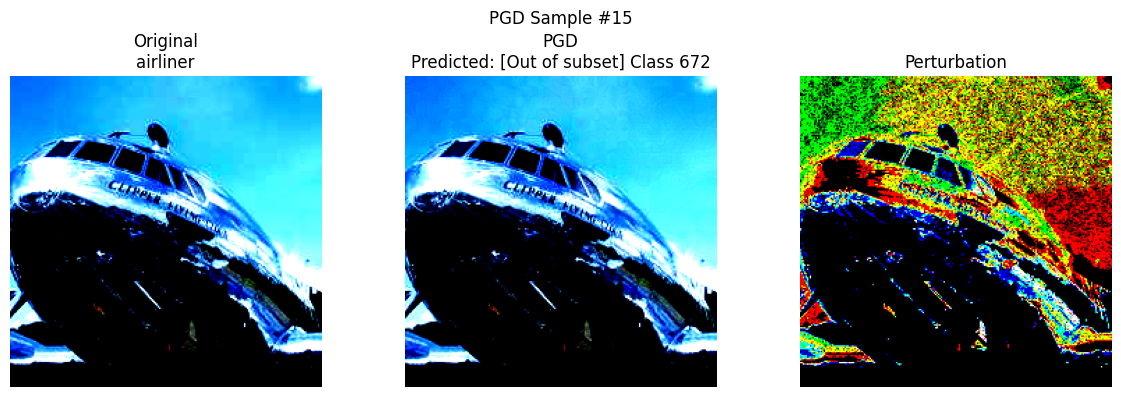

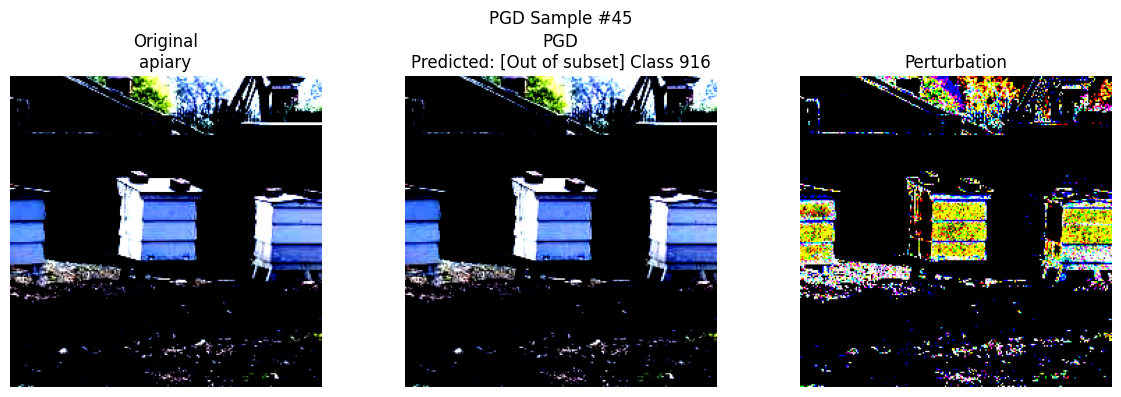

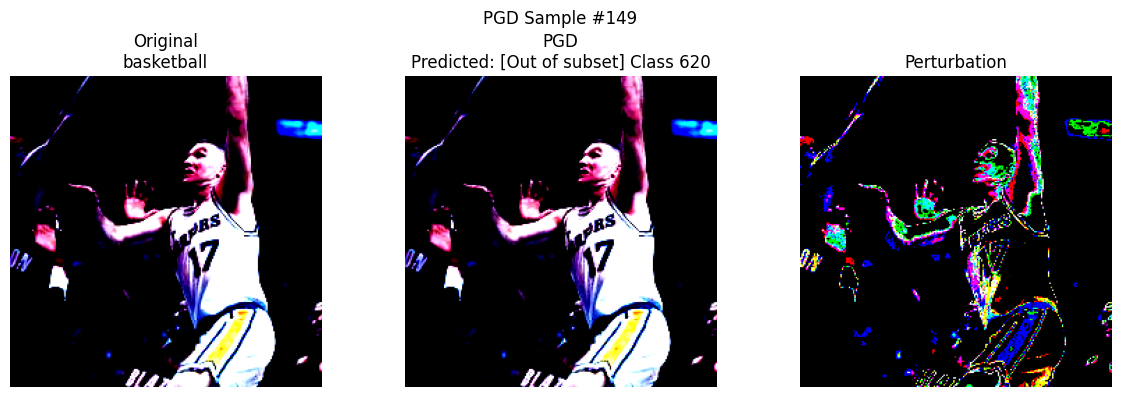

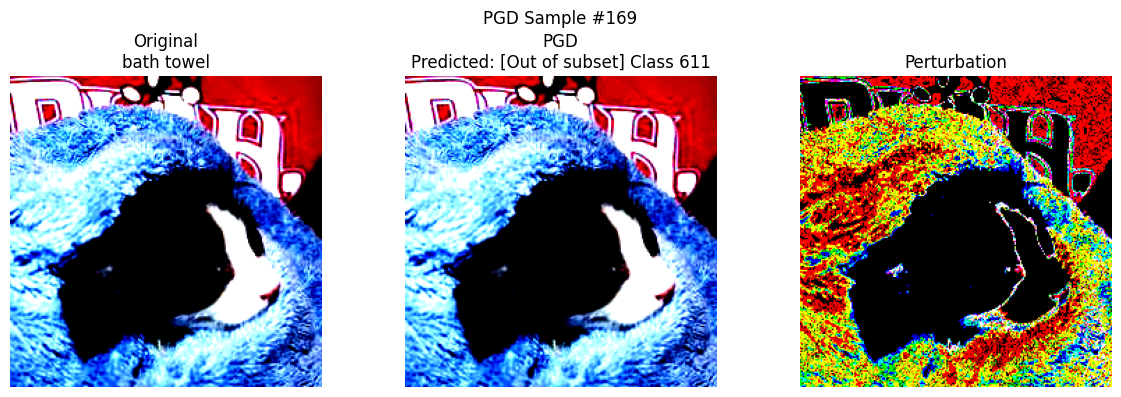

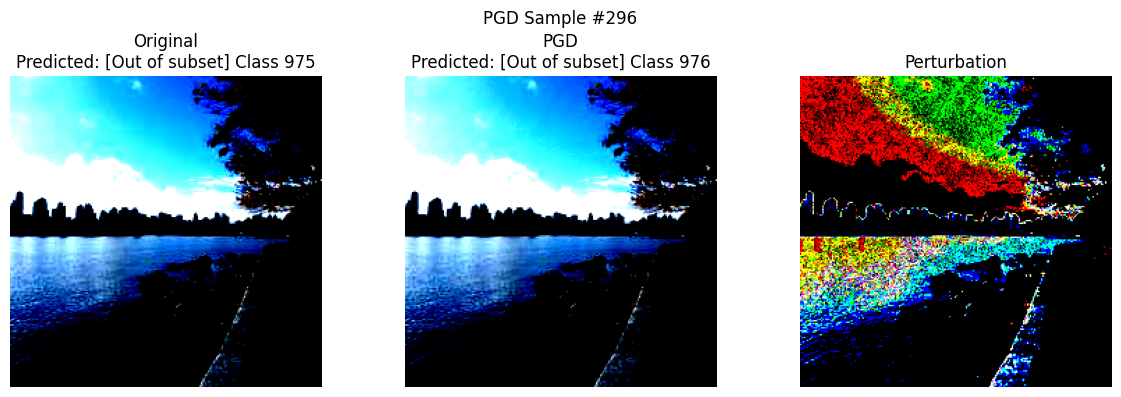

In [26]:

# === Visualization of PGD Adversarial vs Original Images ===
def show_adversarial_comparison(orig_dataset, adv_dataset_images, model, indices, attack_name="PGD"):
    model.eval()
    for idx in indices:
        orig_img, _ = orig_dataset[idx]
        orig_tensor = orig_img.unsqueeze(0).to(device).float()
        adv_tensor = adv_dataset_images[idx].unsqueeze(0).to(device).float()

        with torch.no_grad():
            orig_pred = model(orig_tensor).argmax(dim=1).item()
            adv_pred = model(adv_tensor).argmax(dim=1).item()

        orig_label = id_to_classname.get(orig_pred, f"Predicted: [Out of subset] Class {orig_pred}")
        adv_label = id_to_classname.get(adv_pred, f"Predicted: [Out of subset] Class {adv_pred}")

        orig_np = torch.clamp(orig_tensor[0], 0, 1).detach().permute(1, 2, 0).cpu().numpy()
        adv_np = torch.clamp(adv_tensor[0], 0, 1).detach().permute(1, 2, 0).cpu().numpy()

        diff_np = np.abs(adv_np - orig_np)

        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(orig_np)
        axs[0].set_title(f"Original\n{orig_label}")
        axs[1].imshow(adv_np)
        axs[1].set_title(f"{attack_name}\n{adv_label}")
        axs[2].imshow(diff_np / diff_np.max())
        axs[2].set_title("Perturbation")
        for ax in axs: ax.axis('off')
        plt.suptitle(f"{attack_name} Sample #{idx}", fontsize=12)
        plt.tight_layout()
        plt.show()

# Sample indices used for consistent comparison
sample_indices = [15, 45, 149, 169, 296]
show_adversarial_comparison(
    orig_dataset=image_dataset,
    adv_dataset_images=adv2_dataset_images,
    model=resnet_model,
    indices=sample_indices,
    attack_name="PGD"
)

## Task 4

In [33]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, datasets, models
import json
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pretrained ResNet-34 model
resnet_model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
resnet_model.eval().to(device)

# Define normalization (ImageNet statistics)
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

# Dataset (normalized version for evaluation)
transform_pipeline = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

dataset_path = "content/TestDataSet/TestDataSet"
image_dataset = datasets.ImageFolder(root=dataset_path, transform=transform_pipeline)
data_loader = DataLoader(image_dataset, batch_size=32, shuffle=False)

print(f"📂 Dataset loaded with {len(image_dataset)} images from {len(image_dataset.classes)} categories.")

# Load class label mappings (same as Task 1)
json_path = os.path.join(dataset_path, "labels_list.json")
with open(json_path, "r") as f:
    label_data = json.load(f)

# Mapping ImageNet class labels to dataset class indices
imagenet_label_ids = [int(line.split(":")[0]) for line in label_data]
folder_to_imagenet = {folder: imagenet_label_ids[i] for i, folder in enumerate(image_dataset.classes)}
id_to_classname = {int(line.split(":")[0]): line.split(":")[1].strip() for line in label_data}

# === Step 1: Define Patch Attack (PGD style) ===
def patch_attack(model, images, labels, epsilon=0.3, alpha=0.03, iters=10, patch_size=32):
    ori_images = images.clone().detach().to(device)
    images = ori_images.clone().detach().requires_grad_(True)
    _, _, H, W = images.shape

    # Randomly select a patch region
    top = torch.randint(0, H - patch_size, (1,)).item()
    left = torch.randint(0, W - patch_size, (1,)).item()

    for _ in range(iters):
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)
        model.zero_grad()
        loss.backward()

        grad = images.grad
        patch = grad[:, :, top:top+patch_size, left:left+patch_size].sign()
        images.data[:, :, top:top+patch_size, left:left+patch_size] += alpha * patch

        # Clip the perturbed patch to satisfy the L∞ constraint
        delta = torch.clamp(images - ori_images, -epsilon, epsilon)
        images.data = torch.clamp(ori_images + delta, 0, 1).detach()
        images.requires_grad = True

    return images.detach()

# === Step 2: Generate Adversarial Test Set 3 ===
adv3_images_list, adv3_labels_list = [], []
for images, labels in tqdm(data_loader, desc="Generating Patch Adversarial Images"):
    images = images.to(device)
    true_labels = torch.tensor([folder_to_imagenet[image_dataset.classes[t]] for t in labels]).to(device)

    adv_images = patch_attack(resnet_model, images, true_labels, epsilon=0.3, alpha=0.03, iters=10)

    adv3_images_list.append(adv_images.cpu())
    adv3_labels_list.append(true_labels.cpu())

adv3_dataset_images = torch.cat(adv3_images_list)
adv3_dataset_labels = torch.cat(adv3_labels_list)

# === Step 3: Verify L∞ Constraint ===
def verify_linf_raw(orig_dataset, adv_tensor, epsilon=0.3, attack_name="Patch Attack"):
    max_diffs = [
        torch.abs(orig_dataset[i][0] - adv_tensor[i].cpu()).max().item()
        for i in range(len(orig_dataset))
    ]
    max_val = max(max_diffs)
    print(f"🔎 {attack_name} - Max L∞ distance: {max_val:.6f}")

    if max_val <= epsilon + 1e-6:
        print(f"✔️ {attack_name} - ε constraint satisfied\n")
    else:
        print(f"❌ {attack_name} - ε constraint violated\n")

verify_linf_raw(image_dataset, adv3_dataset_images, epsilon=0.3, attack_name="Patch Attack")

# === Step 4: Evaluate Accuracy on Adversarial Set 3 ===
adv3_loader = DataLoader(list(zip(adv3_dataset_images, adv3_dataset_labels)), batch_size=32)
patch_top1, patch_top5, total = 0, 0, 0

with torch.no_grad():
    for images, labels in tqdm(adv3_loader, desc="Evaluating on Patch Adversarial Set"):
        images, labels = images.to(device), labels.to(device)
        outputs = resnet_model(images)
        _, top5_preds = outputs.topk(5, dim=1)

        patch_top1 += (top5_preds[:, 0] == labels).sum().item()
        patch_top5 += sum([labels[i].item() in top5_preds[i] for i in range(images.size(0))])
        total += images.size(0)

patch_top1_acc = patch_top1 / total
patch_top5_acc = patch_top5 / total

print(f"⚠️ Patch Attack Top-1 Accuracy: {patch_top1_acc:.4f}")
print(f"⚠️ Patch Attack Top-5 Accuracy: {patch_top5_acc:.4f}")

📂 Dataset loaded with 500 images from 100 categories.


Generating Patch Adversarial Images: 100%|██████████| 16/16 [00:08<00:00,  1.89it/s]


🔎 Patch Attack - Max L∞ distance: 2.117904
❌ Patch Attack - ε constraint violated



Evaluating on Patch Adversarial Set: 100%|██████████| 16/16 [00:00<00:00, 17.50it/s]


⚠️ Patch Attack Top-1 Accuracy: 0.2400
⚠️ Patch Attack Top-5 Accuracy: 0.4660


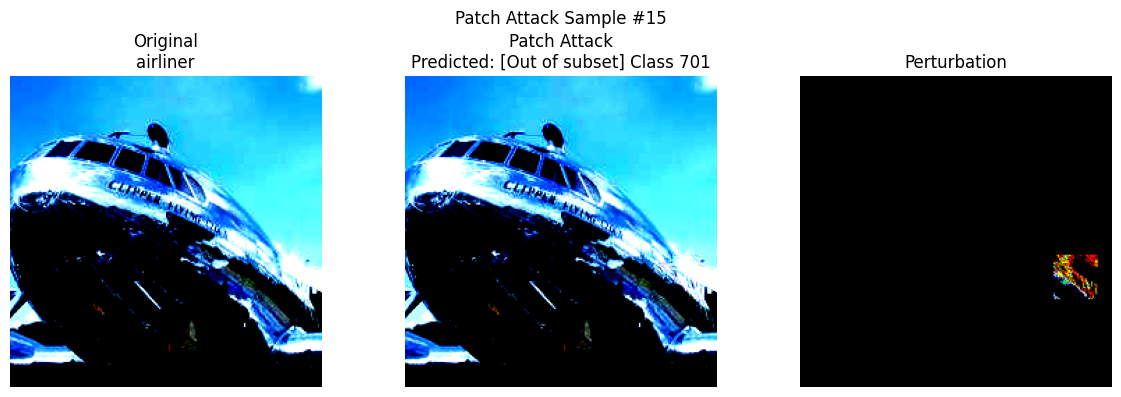

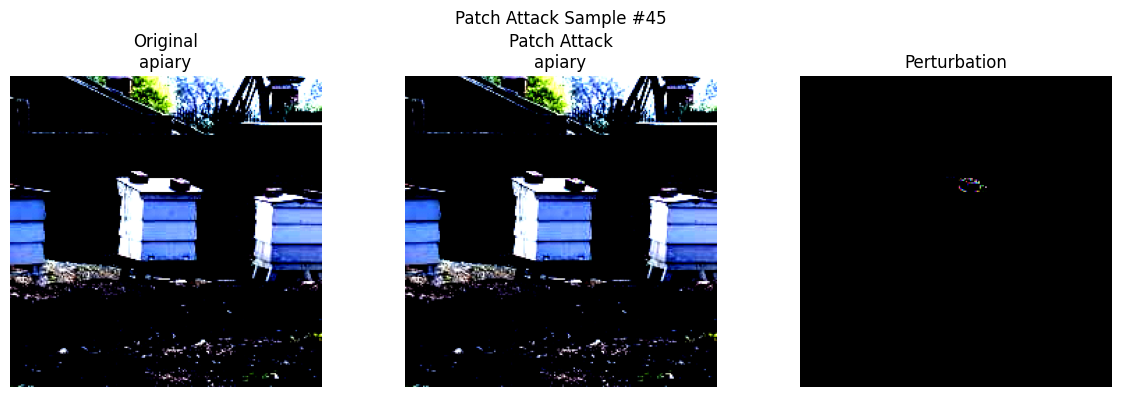

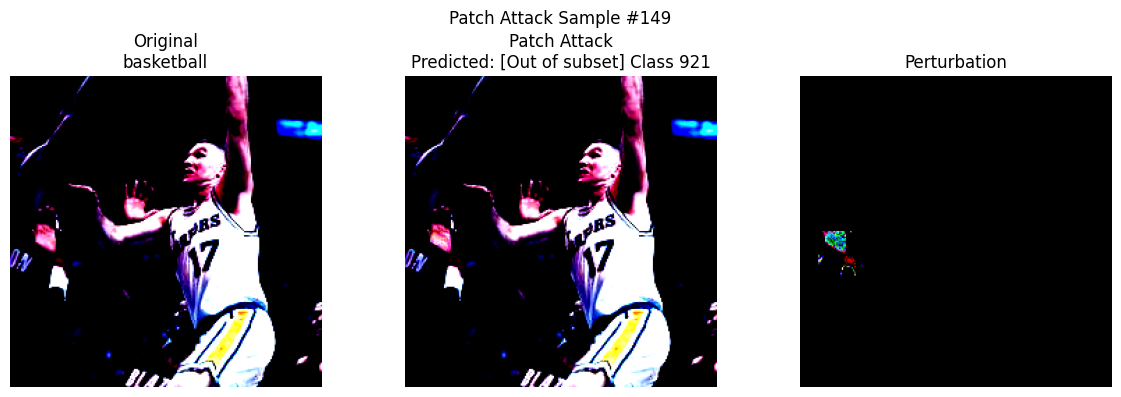

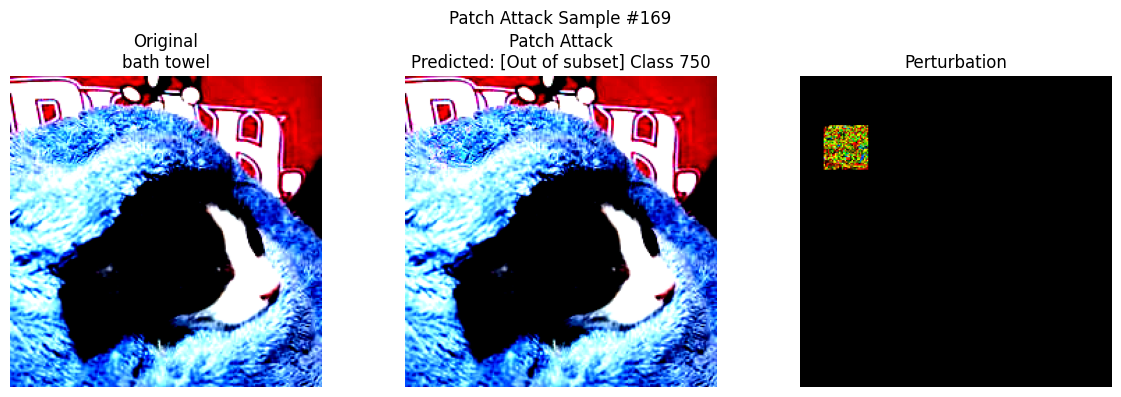

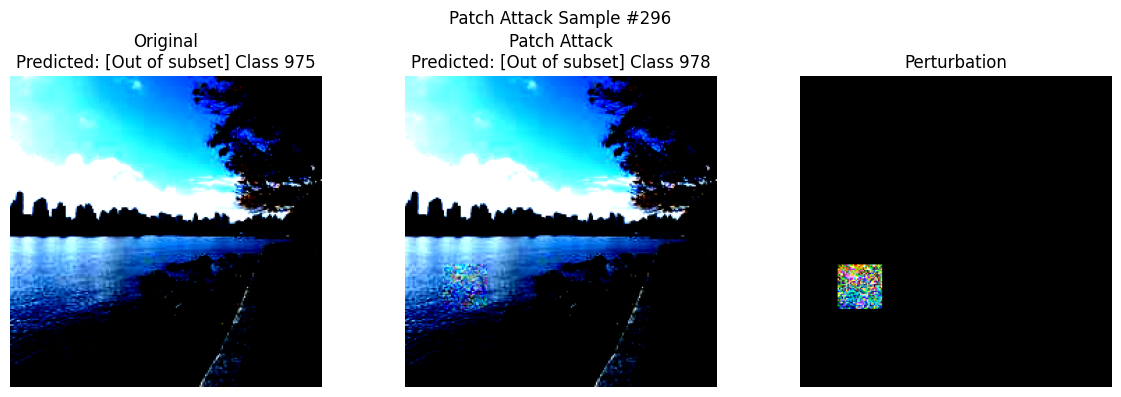

In [34]:
# === Step 5: Visualize a few patch attack examples ===
sample_indices = sample_indices = [15, 45, 149, 169, 296]
def show_adversarial_comparison(orig_dataset, adv_dataset_images, model, indices, attack_name="Patch Attack"):
    model.eval()
    for idx in indices:
        orig_img, _ = orig_dataset[idx]
        orig_tensor = orig_img.unsqueeze(0).to(device).float()
        adv_tensor = adv_dataset_images[idx].unsqueeze(0).to(device).float()

        with torch.no_grad():
            orig_pred = model(orig_tensor).argmax(dim=1).item()
            adv_pred = model(adv_tensor).argmax(dim=1).item()

        orig_label = id_to_classname.get(orig_pred, f"Predicted: [Out of subset] Class {orig_pred}")
        adv_label = id_to_classname.get(adv_pred, f"Predicted: [Out of subset] Class {adv_pred}")

        orig_np = torch.clamp(orig_tensor[0], 0, 1).detach().permute(1, 2, 0).cpu().numpy()
        adv_np = torch.clamp(adv_tensor[0], 0, 1).detach().permute(1, 2, 0).cpu().numpy()

        diff_np = np.abs(adv_np - orig_np)

        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(orig_np)
        axs[0].set_title(f"Original\n{orig_label}")
        axs[1].imshow(adv_np)
        axs[1].set_title(f"{attack_name}\n{adv_label}")
        axs[2].imshow(diff_np / diff_np.max())
        axs[2].set_title("Perturbation")
        for ax in axs: ax.axis('off')
        plt.suptitle(f"{attack_name} Sample #{idx}", fontsize=12)
        plt.tight_layout()
        plt.show()

show_adversarial_comparison(
    orig_dataset=image_dataset,
    adv_dataset_images=adv3_dataset_images,
    model=resnet_model,
    indices=sample_indices,
    attack_name="Patch Attack"
)

# Save the new adversarial dataset
torch.save((adv3_dataset_images, adv3_dataset_labels), "Adversarial_Test_Set_3.pt")

## Task 5

In [36]:
# Imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, datasets, models
import json
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained DenseNet-121 model (other than ResNet-34)
transfer_model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
transfer_model.eval().to(device)

# Define normalization (ImageNet statistics)
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

# Dataset (normalized version for evaluation)
transform_pipeline = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

dataset_path = "content/TestDataSet/TestDataSet"
image_dataset = datasets.ImageFolder(root=dataset_path, transform=transform_pipeline)
data_loader = DataLoader(image_dataset, batch_size=32, shuffle=False)

print(f"📂 Dataset loaded with {len(image_dataset)} images from {len(image_dataset.classes)} categories.")

📂 Dataset loaded with 500 images from 100 categories.


In [37]:
# Load class label mappings (same as Task 1)
json_path = os.path.join(dataset_path, "labels_list.json")
with open(json_path, "r") as f:
    label_data = json.load(f)

# Mapping ImageNet class labels to dataset class indices
imagenet_label_ids = [int(line.split(":")[0]) for line in label_data]
folder_to_imagenet = {folder: imagenet_label_ids[i] for i, folder in enumerate(image_dataset.classes)}
id_to_classname = {int(line.split(":")[0]): line.split(":")[1].strip() for line in label_data}

# === Step 2: Prepare original clean dataset tensors ===
original_images = torch.stack([image_dataset[i][0] for i in range(len(image_dataset))])
original_labels = torch.tensor([folder_to_imagenet[image_dataset.classes[image_dataset[i][1]]] for i in range(len(image_dataset))])

# === Step 3: Load adversarial test sets from disk ===
adv1_images, adv1_labels = torch.load("Adversarial_Test_Set_1.pt")  # FGSM
adv2_images, adv2_labels = torch.load("Adversarial_Test_Set_2.pt")  # PGD
adv3_images, adv3_labels = torch.load("Adversarial_Test_Set_3.pt")  # Patch

# Evaluation function for top-1 and top-5 accuracy
def evaluate_model(model, image_tensor, label_tensor, name="Set"):
    loader = DataLoader(list(zip(image_tensor, label_tensor)), batch_size=32)
    top1, top5, total = 0, 0, 0

    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, top5_preds = outputs.topk(5, dim=1)
            top1 += (top5_preds[:, 0] == labels).sum().item()
            top5 += sum([labels[i].item() in top5_preds[i] for i in range(images.size(0))])
            total += images.size(0)

    top1_acc = top1 / total
    top5_acc = top5 / total
    print(f"{name} → Top-1: {top1_acc:.4f}, Top-5: {top5_acc:.4f}")
    return top1_acc, top5_acc

# === Step 4: Evaluate each dataset on the transfer model ===
evaluate_model(transfer_model, original_images, original_labels, name="Clean Set")
evaluate_model(transfer_model, adv1_images, adv1_labels, name="FGSM Set")
evaluate_model(transfer_model, adv2_images, adv2_labels, name="PGD Set")
evaluate_model(transfer_model, adv3_images, adv3_labels, name="Patch Set")

Clean Set → Top-1: 0.7480, Top-5: 0.9360
FGSM Set → Top-1: 0.4240, Top-5: 0.6660
PGD Set → Top-1: 0.3900, Top-5: 0.6340
Patch Set → Top-1: 0.4440, Top-5: 0.6640


(0.444, 0.664)

| Dataset          | Model          | Top-1 Accuracy | Top-5 Accuracy |
|------------------|----------------|----------------|----------------|
| Clean Set        | ResNet-34      | 0.7480         | 0.9360         |
| FGSM Set         | ResNet-34      | 0.4240         | 0.6660         |
| PGD Set          | ResNet-34      | 0.3900         | 0.6340         |
| Patch Set        | ResNet-34      | 0.4440         | 0.6640         |
| Clean Set        | DenseNet-121   | 0.7620         | 0.9420         |
| FGSM Set         | DenseNet-121   | 0.2640         | 0.5060         |
| PGD Set          | DenseNet-121   | 0.0040         | 0.0680         |
| Patch Set        | DenseNet-121   | 0.2400         | 0.4660         |
